In [1]:
import pickle as pkl
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import numpy as np

import sys
sys.path.append('..')
from evaluate import get_last_N, get_predictions, evaluate_model_ensembles


%matplotlib inline

In [17]:
df_full = pd.read_csv('../reports/result_df.csv')
print(df_full.shape)
df = df_full[df_full['num'].isna()].dropna(axis=1)
df = df[df['loss'] != 'mse']
print(df.shape)

(2544, 9)
(153, 8)


In [2]:
x, y = pkl.load(open('../data/yearly_24_train_line.pkl', 'rb'))

x.shape, y.shape

((176595, 18), (176595, 6))

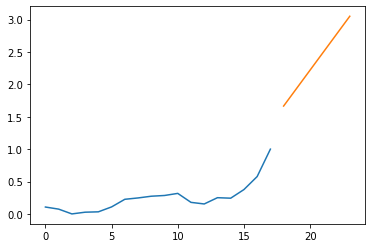

In [3]:
i = 8
plt.plot(range(18), x[i])
plt.plot(range(18, 24), y[i])

In [4]:
# Read test data
train_path = Path('../data/Yearly-train.csv')
test_path = Path('../data/Yearly-test.csv')

train = pd.read_csv(train_path).drop('V1', axis=1)
test = pd.read_csv(test_path).drop('V1', axis=1)

In [5]:
# Read experiments
p = Path('../results').absolute()

trials = [t for t in p.glob('*') if t.name.startswith('line')]
families = set([p / '__'.join(t.name.split('__')[:-1]) for t in trials])
num_models = [len(list(p.glob(f.name + '*'))) for f in families]

num_inputs = np.unique([f.name[10:12] for f in families])

In [12]:
for inp in num_inputs:
    X_test = np.array([get_last_N(ser[1], N=int(inp)) for ser in train.iterrows()])
    y_test = test.values

    curr_family_list = [(f, m) for f, m in zip(families, num_models) if f.name[10:12] == inp]

    results = evaluate_model_ensembles(curr_family_list, X_test, y_test)

  0%|          | 0/1 [00:00<?, ?it/s]

[[ 7260.4976   7283.4785   7379.7183  ...  7412.3135   7465.019
   7508.3    ]
 [ 1002.65454  1086.4125   1008.5829  ...  1672.114    1700.2799
   1723.6967 ]
 [ 7058.532    7220.5293   7389.5566  ...  9336.039    9578.053
   9823.707  ]
 ...
 [ 1215.5361   1275.2872   1707.7887  ...  1071.1835   1122.9613
   1166.5062 ]
 [ 3535.2842   3298.8735   3997.9946  ...  6818.029    7115.9976
   7318.022  ]
 [ 7372.747    7513.4126   7765.463   ...  9614.338    9829.178
  10051.791  ]]
[[7267.4395 7281.776  7394.7393 ... 7445.176  7485.199  7521.444 ]
 [1042.1207 1069.1105 1042.9104 ... 1696.6196 1727.2847 1755.9297]
 [7096.4106 7252.8154 7391.0547 ... 9321.506  9548.922  9772.08  ]
 ...
 [1223.5765 1322.986  1568.2767 ... 1080.4634 1133.1211 1171.7501]
 [3560.091  3327.3677 4322.352  ... 6963.294  7114.581  7267.075 ]
 [7366.927  7526.1987 7746.421  ... 9420.193  9586.973  9741.601 ]]
[[7240.7285  7239.149   7376.5327  ... 7435.162   7494.4404  7537.1865 ]
 [ 996.98804 1014.8852  1016.4308  .

100%|██████████| 1/1 [11:38<00:00, 698.13s/it]

[[ 7251.8213   7311.756    7392.299   ...  7480.209    7527.0015
   7565.2095 ]
 [ 1002.79114  1053.1974   1014.38165 ...  1631.4526   1656.3208
   1665.5491 ]
 [ 7057.8745   7296.591    7389.5293  ...  9364.358    9616.242
   9882.51   ]
 ...
 [ 1192.764    1336.1271   1720.793   ...  1210.7579   1258.7166
   1296.8344 ]
 [ 3573.225    3512.858    3923.8896  ...  7210.657    7341.8774
   7526.8247 ]
 [ 7348.3613   7562.161    7746.419   ...  9695.481    9932.172
  10159.959  ]]


In [16]:
results['smape']

{'line__inp_18__out_14__loss_mae__bksize_200__bkact_relu__dir_bi__0': 13.385204909280153,
 'line__inp_18__out_14__loss_mae__bksize_200__bkact_relu__dir_bi__1': 13.148536178370128,
 'line__inp_18__out_14__loss_mae__bksize_200__bkact_relu__dir_bi__2': 13.331064902475836,
 'line__inp_18__out_14__loss_mae__bksize_200__bkact_relu__dir_bi__3': 13.183959215252354,
 'line__inp_18__out_14__loss_mae__bksize_200__bkact_relu__dir_bi__4': 13.348886275323277,
 'line__inp_18__out_14__loss_mae__bksize_200__bkact_relu__dir_bi__5': 13.121486991957624,
 'line__inp_18__out_14__loss_mae__bksize_200__bkact_relu__dir_bi__6': 13.155546758821867,
 'line__inp_18__out_14__loss_mae__bksize_200__bkact_relu__dir_bi__7': 13.142061376165861,
 'line__inp_18__out_14__loss_mae__bksize_200__bkact_relu__dir_bi__8': 13.195802938517588,
 'line__inp_18__out_14__loss_mae__bksize_200__bkact_relu__dir_bi__9': 13.052679514189103,
 'line__inp_18__out_14__loss_mae__bksize_200__bkact_relu__dir_bi__10': 13.546431877090294,
 'line__i

(12.9, 13.3)

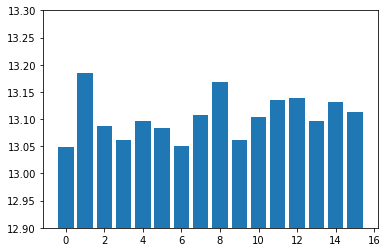

In [31]:
r = list(df[(df['input_len'] == 18) & (df['output_len'] == 14)]['smape']) + [results['smape']['line__inp_18__out_14__loss_mae__bksize_200__bkact_relu__dir_bi']]

plt.bar(range(len(r)), height=r)
plt.ylim([12.9, 13.3])